In [2]:
%reload_ext autoreload
%autoreload 2

#import pyexoplaneteu  # for accesing exoplanet.eu database
import numpy as np
import os
import pandas as pd
import utils as ut
from astropy.io import votable
import plot_utils as pu

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'monospace'

savefold = '../figures/host_star_stats/'

Let's first analyze the statistics of the confirmed exoplanet database by looking up how many transists:
- Have host star age determined
- Are transits 
- Both
- How many have erro estimates on the star age

In [3]:
data_NASA = votable.parse_single_table('../data/database_NASA.votable')
df = data_NASA.to_table().to_pandas()

# Count and filter relevant data
total_exos = len(df)
df_t = df[df['tran_flag'] == '1']
total_exos_t = len(df_t)
total_exos_age = len(df.dropna(subset=['st_age']))
total_exos_age_t = len(df_t.dropna(subset=['st_age']))
total_exos_age_error_t = len(df_t.dropna(subset=['st_ageerr1']))  #st_ageerr1 is the upper error

# # Print statistics
print(f"{total_exos_t} out of {total_exos} ({100 * total_exos_t / total_exos:.2f}%) have transit data.")
print(f"{total_exos_age} out of {total_exos} ({100 * total_exos_age / total_exos:.2f}%) have host star age determined.")
print(f"{total_exos_age_t} out of {total_exos_t} ({100 * total_exos_age_t / total_exos_t:.2f}%) transits have host star age.")
print(f"{total_exos_age_error_t} out of {total_exos_t} ({100 * total_exos_age_error_t / total_exos_t:.2f}%) transits have age error estimates.")


print(f"{total_exos_age_t} out of {total_exos} ({100 * total_exos_age_error_t / total_exos:.2f}%) confirmed planets have transit data and have host star age determined.")


4160 out of 5528 (75.25%) have transit data.
4329 out of 5528 (78.31%) have host star age determined.
3491 out of 4160 (83.92%) transits have host star age.
3389 out of 4160 (81.47%) transits have age error estimates.
3491 out of 5528 (61.31%) confirmed planets have transit data and have host star age determined.


We can now look at the distribution of host star ages for the confirmed transits

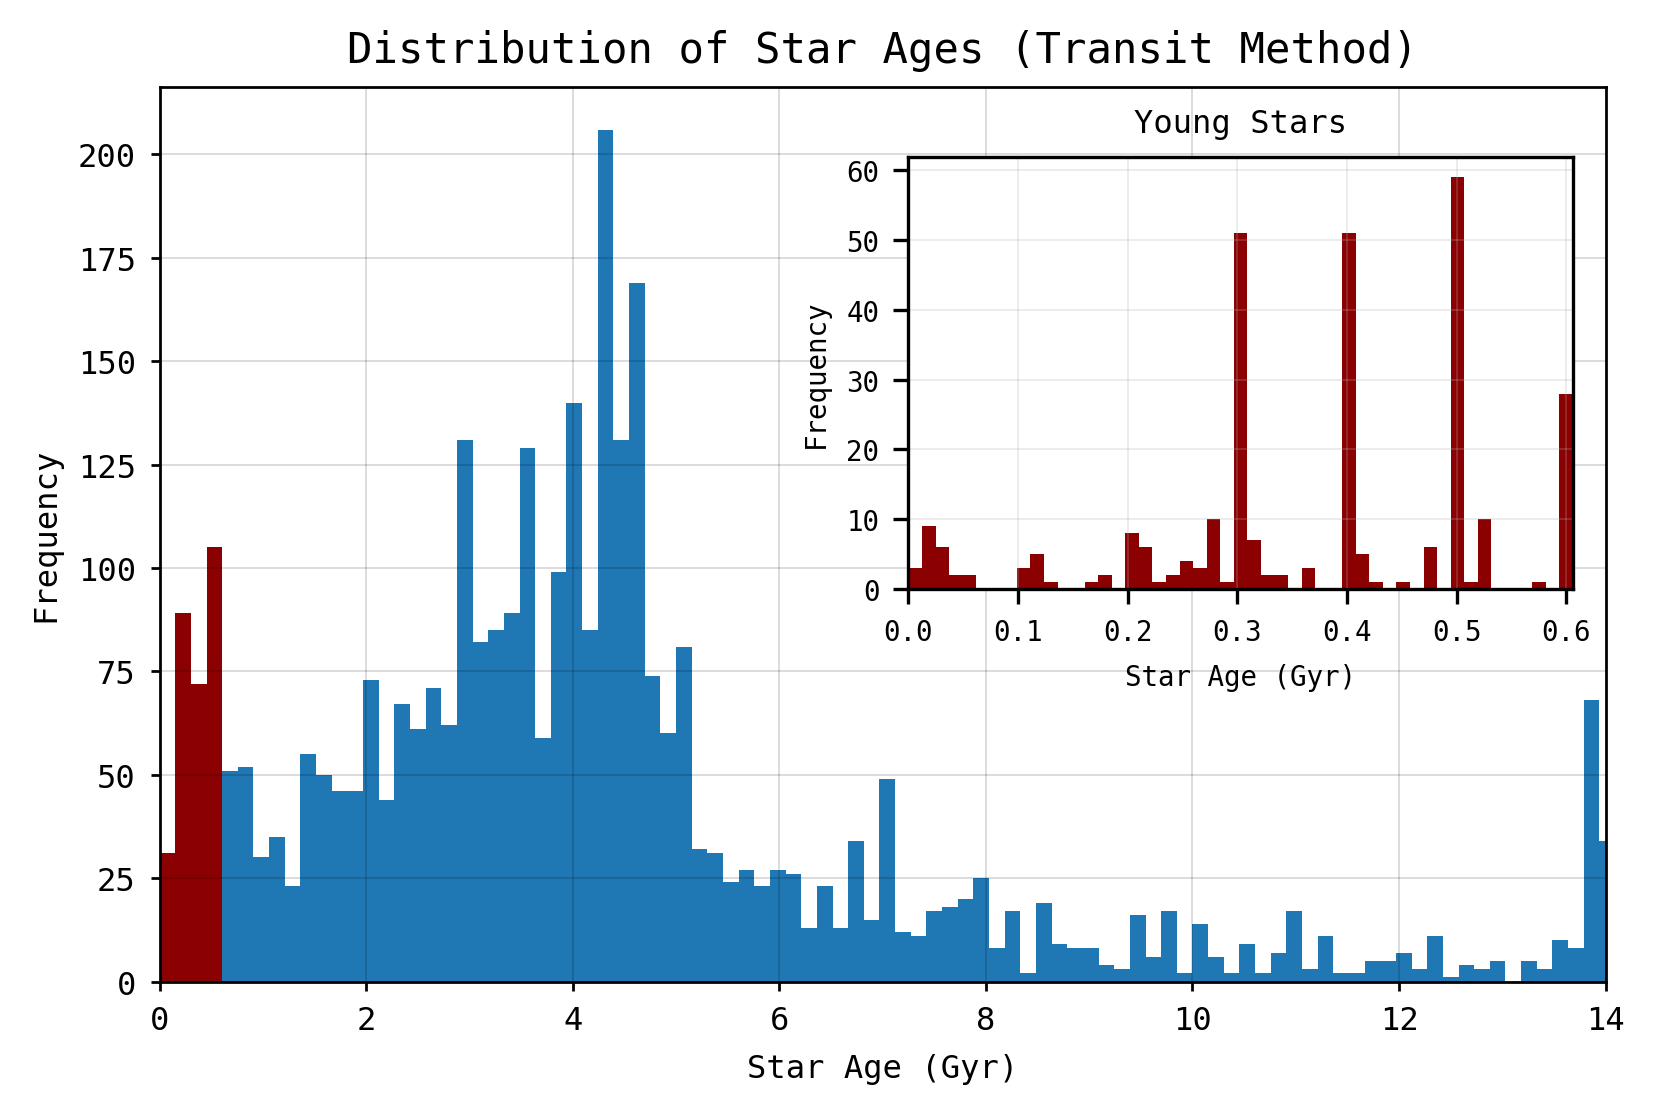

In [4]:
fig, ax, fs = pu.simp_figure(fig_w=1080*3/2, fig_h=1080, 
                             theme=None)

young_lim = 0.606
custom_bins_whole = np.linspace(0, 15, 100)
custom_bins_smol = np.linspace(0, young_lim, 50)

n, bins, patches = ax.hist(df_t['st_age'].dropna(), bins=custom_bins_whole, edgecolor=None, alpha=1)
for i in range(4):
    patches[i].set_facecolor('darkred')

# Set axis labels and title
ax.set_xlabel('Star Age (Gyr)', fontsize=1.75 * fs)
ax.set_ylabel('Frequency', fontsize=1.75 * fs)
ax.tick_params(axis='both', which='major', labelsize=1.75 * fs)


inner_pos=[0.55, 0.47, 0.41, 0.4] 
# Add inner subplot
ax_in = fig.add_axes(inner_pos)
# set tick size and label size of inner subplot

ax_in.tick_params(axis='both', which='major', labelsize=1.5 * fs)
ax_in.set_xlabel('Star Age (Gyr)', fontsize=1.5 * fs)
ax_in.set_ylabel('Frequency', fontsize=1.5 * fs)
ax_in.hist(df_t['st_age'].dropna(), bins=custom_bins_smol, edgecolor=None, alpha=1, color='darkred')
ax_in.set_title('Young Stars', fontsize=1.75 * fs, color='k', zorder=3)
ax_in.grid(which='major', linewidth=fs * 0.025)
ax.set_title('Distribution of Star Ages (Transit Method)', fontsize=2.3 * fs, color='k')

ax.set_xlim([0, 14])
ax_in.set_xlim([0, young_lim])


if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'trans_meth_distr_age.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()

Let's now plot the host star ages with their error bars

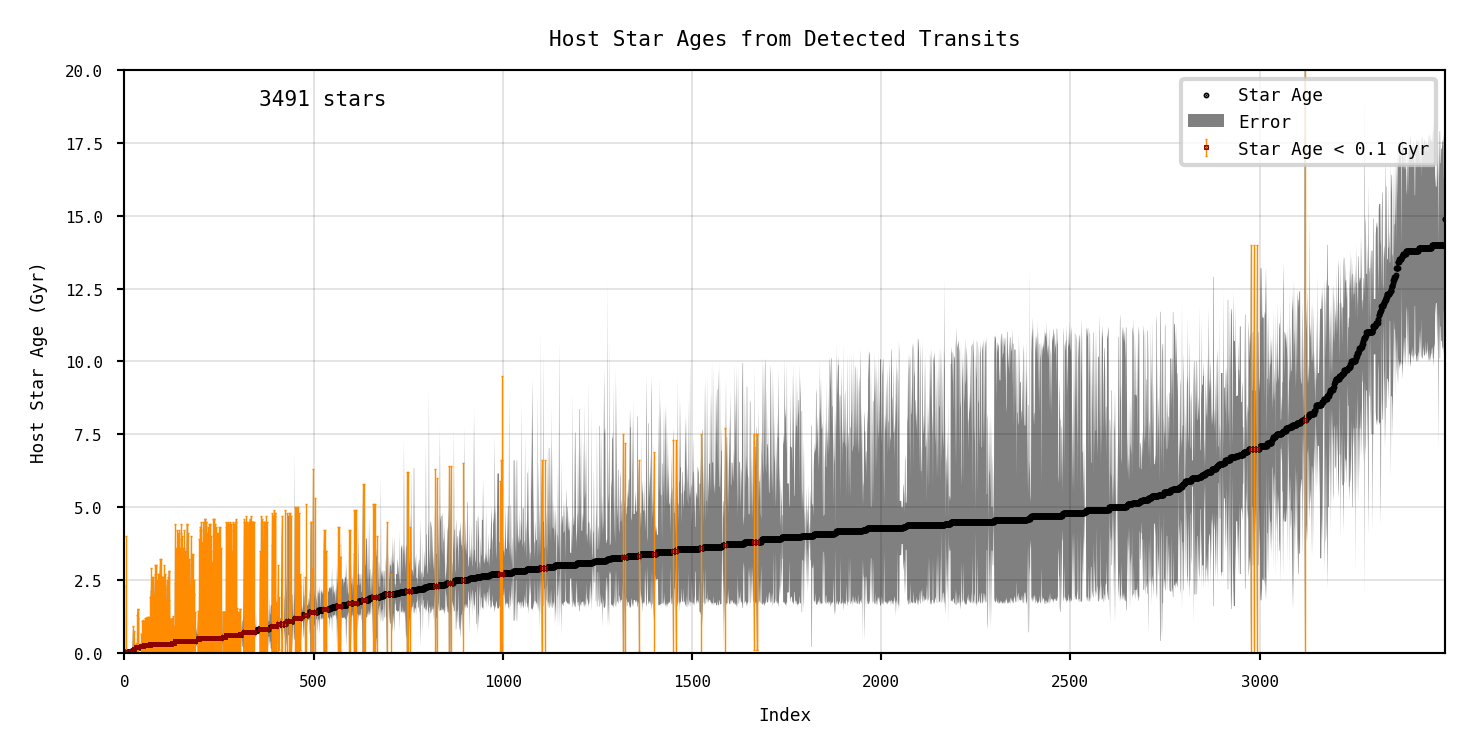

In [5]:
data_NASA = votable.parse_single_table('../data/database_NASA2.votable')
df = data_NASA.to_table().to_pandas()
df = df[df['tran_flag'] == '1']
df = df.dropna(subset=['st_age']) # Drop rows with no age information
df = df.sort_values(by='st_age').reset_index(drop=True)  # Sort by host star age
df['st_ageerr1'].fillna(0, inplace=True)
df['st_ageerr2'].fillna(0, inplace=True)


age_lim = 0.1  # This is the age limit in Gyr for considering a star young
df_filt = df.loc[df['st_age'] - np.abs(df['st_ageerr2']) < age_lim]

# Initialize plot using function defined in the plot_utils.py file
rat = 2
size = 720
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, ratio=None, theme=None, subplots=subplots, text_size=0.75)
ax = axs[0][0]
ms, capsize, ew = 0.05, 0.1, 0.1

x, y, yerr = ut.get_params_nasa(df)
yerr_lower, yerr_upper = yerr

y2, yerr_lower2, yerr_upper2 = [], [], []
for i, val in enumerate(y):
    if val - yerr[0][i] < age_lim:
        y2.append(val)
        yerr_lower2.append(yerr[0][i])
        yerr_upper2.append(yerr[1][i])
    else:
        y2.append(np.nan)
        yerr_lower2.append(np.nan)
        yerr_upper2.append(np.nan)
yerr2 = [yerr_lower2, yerr_upper2]

# Plot the data points
ax.scatter(x, y, color='black', label='Star Age', s=ms*fs, zorder=2)

# Plot the error as filled region
ax.fill_between(x, y - yerr_lower, y + yerr_upper, color='grey', alpha=1, lw=0, zorder=1, label='Error')
ax.errorbar(x, y2, yerr2, fmt='s', color='darkred', ecolor='darkorange', 
            capsize=capsize*fs, markersize=ms*fs, elinewidth=ew*fs, capthick=ew*fs, 
            label=f'Star Age < {age_lim} Gyr')

ax.set_title('Host Star Ages from Detected Transits', fontsize=fs*1.5)
ax.set_xlabel('Index', fontsize=fs*1.25)
ax.set_ylabel('Host Star Age (Gyr)', fontsize=fs*1.25)
ax.legend(loc='upper right', fontsize=fs*1.25)

ax.set_ylim(0, 20)
ax.set_xlim(0, x[-1])

#text in the middle with the number of stars
ax.text(0.15, 0.95, f'{len(y2)} stars', fontsize=fs*1.5, transform=ax.transAxes, ha='center', va='center')

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'sorted_host_star_ages.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()


Comments about figure above:
 - Some top error bars are gigantic (we take those as they are)
 - Some bottom error bars are also very big, which does not make sense as it would mean negative values for the star age.
 - Some host stars may be duplicated! This is because several different planets may have been detected via transit method around the same host star. 

### Cumulative Distribution of Stars by Age: Considering Error Bars

The following cell generates a bar plot that visualizes the cumulative distribution of transits whose host star age lays under a certain age limit. The graph has two sets of bars:

1. **Considering low error bound**: This set represents the number of stars that fall below each age threshold when taking into account the lower error bound.
2. **No error considered**: This set represents the raw count of stars that fall below each age threshold, without considering any error bars.

The x-axis indicates the age thresholds (in Gyr), and the y-axis shows the number of confirmed transits whose host star falls below each age threshold.

By analyzing this distribution, we aim to understand how accounting for error in the age measurements affects our perspective on the population of host stars.


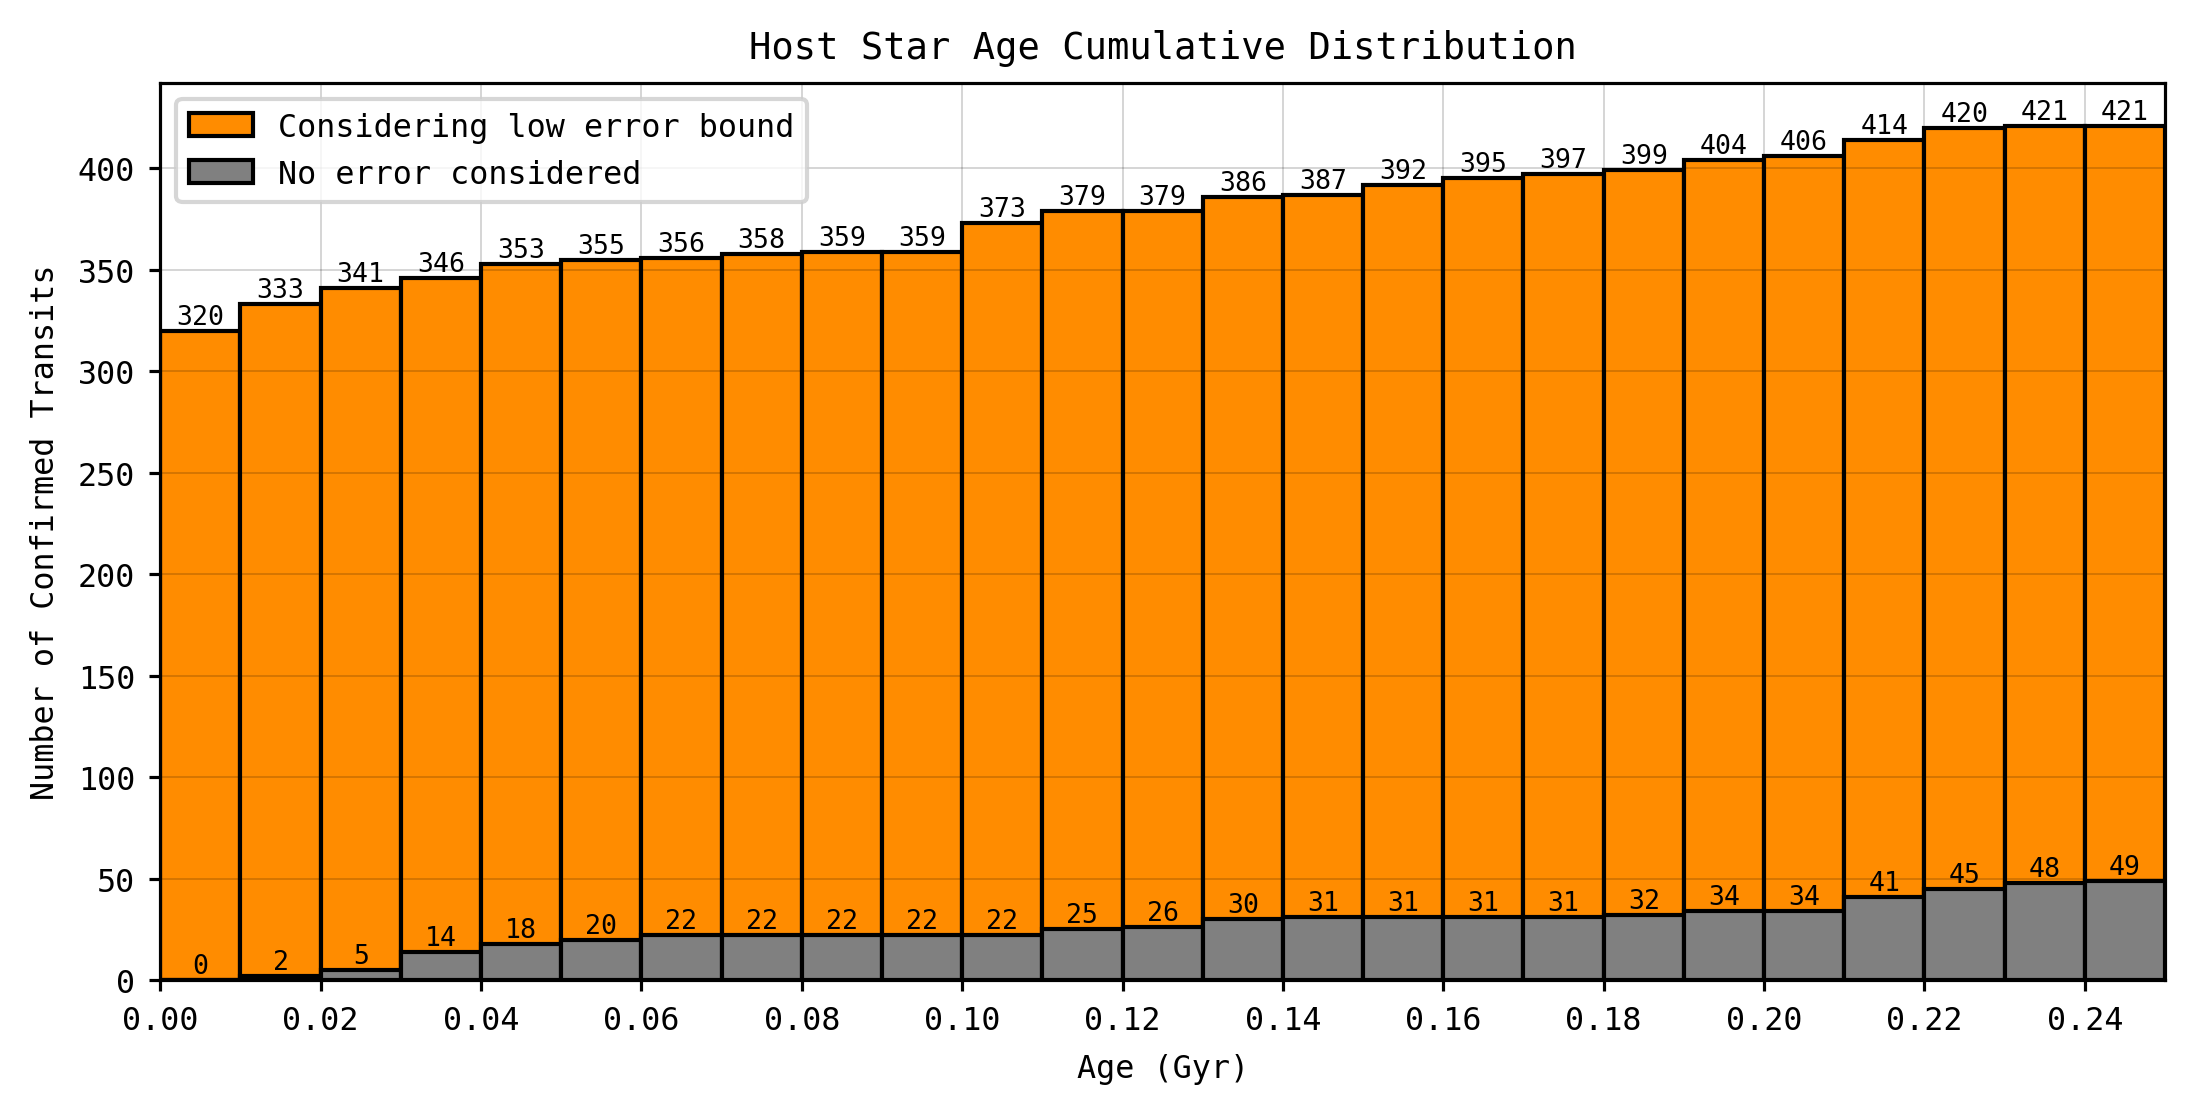

In [6]:
vals = np.linspace(0.00, 0.24, 25)

nums = []
nums_lowerr = []
for val in vals:
    # Indices where y < 0.2
    indices_y = np.where(y < val)[0]
    indices_y2 = np.where(y - yerr_lower < val)[0]
    nums.append(len(indices_y))
    nums_lowerr.append(len(indices_y2))

fig, ax, fs = pu.simp_figure(fig_w=1080*4/2, fig_h=1080, 
                             theme=None)


bar_width = vals[1] - vals[0]  # or any other appropriate value for your data

ax.bar(vals, nums_lowerr, width=bar_width, 
       color='darkorange',
       edgecolor='k', align='edge', label='Considering low error bound')
ax.bar(vals, nums, width=bar_width, 
       color='gray',
       edgecolor='k', align='edge', label='No error considered')

# add the value on top of bars
for i, val in enumerate(vals):
    ax.text(val+bar_width/2, nums[i]+0.5, nums[i], ha='center', va='bottom', fontsize=fs*1.25)
    ax.text(val+bar_width/2, nums_lowerr[i]+0.5, nums_lowerr[i], ha='center', va='bottom', fontsize=fs*1.25)


# Customization like title, labels, legend
ax.set_title('Host Star Age Cumulative Distribution', fontsize=fs*1.75)
ax.set_ylabel('Number of Confirmed Transits', fontsize=fs*1.5)
ax.set_xlabel('Age (Gyr)', fontsize=fs*1.5)
ax.legend(loc='upper left', fontsize=fs*1.5)



ax.set_xticks(vals[::2])
ax.set_xlim(0.00, 0.25) 

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'cum_age_error_plot.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()


In [7]:
text = f'From the {len(df)} stars with confirmed transits whose host star age is determined, {len(df_filt)} are younger than {age_lim} Gy considering error bars.'
print(text)

From the 3491 stars with confirmed transits whose host star age is determined, 373 are younger than 0.1 Gy considering error bars.


Again, this is the number of transists. If we want to get the actual number of different host stars we should do some filtering. Done below.

We save the dataframe with the relevant host stars. 

In [19]:
df_filt = df.loc[df['st_age'] - np.abs(df['st_ageerr2']) < age_lim]
df_filt = df_filt.sort_values(by='st_age').reset_index(drop=True)  
df_filt = df_filt.drop_duplicates(subset='hostname', keep='first')
df_filt.reset_index(inplace=True)
df_filt = df_filt.drop(columns=['pl_name'])
#remove column named index



print('The number of different host stars is', len(df_filt))

savefold = '../results/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'young_stars_below_{age_lim*1e3:0.0f}Myr.csv'
savepath = savefold + figname
df_filt.to_csv(savepath, index=False)


The number of different host stars is 247


In [9]:
df_filt

,pl_name,hostname,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,discoverymethod,disc_year,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
0,Kepler-1663 b,Kepler-1663,,,TIC 407001589,Gaia DR2 2129578826996503040,1,1,Transit,2020,...,-3.40700,16.069,0.160,-0.160,12.552,0.031,-0.031,15.61640,0.000494,-0.000494
1,K2-33 b,K2-33,,,TIC 49040478,Gaia DR2 6245758900889486720,1,1,Transit,2016,...,-1.49900,15.838,0.126,-0.126,10.026,0.019,-0.019,14.15700,0.000900,-0.000900
2,TOI-1227 b,TOI-1227,,,TIC 360156606,Gaia DR2 5842480953772012928,1,1,Transit,2022,...,-0.56600,16.999,1.133,-1.133,11.034,0.021,-0.021,15.25140,0.000848,-0.000848
3,HD 114082 b,HD 114082,HD 114082,HIP 64184,TIC 441546821,Gaia DR2 6055854551117476480,1,1,Radial Velocity,2022,...,-0.44760,8.200,0.030,-0.030,7.163,0.031,-0.031,8.09394,0.000327,-0.000327
4,HIP 67522 b,HIP 67522,HD 120411,HIP 67522,TIC 166527623,Gaia DR2 6113920619134019456,1,1,Transit,2020,...,-1.08700,9.790,0.030,-0.030,8.164,0.026,-0.026,9.63261,0.002283,-0.002283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,GJ 143 b,GJ 143,HD 21749,HIP 16069,TIC 279741379,Gaia DR2 4673947174316727040,1,2,Transit,2019,...,-0.00710,8.080,0.030,-0.030,5.375,0.024,-0.024,7.67906,0.000260,-0.000260
369,WASP-80 b,WASP-80,,,TIC 243921117,Gaia DR2 4223507222112425344,1,1,Transit,2012,...,-0.11605,11.841,0.034,-0.034,8.351,0.022,-0.022,11.27300,0.000824,-0.000824
370,WASP-43 b,WASP-43,,,TIC 36734222,Gaia DR2 3767805209112436736,1,1,Transit,2011,...,-0.32570,12.305,0.057,-0.057,9.267,0.026,-0.026,11.90700,0.001847,-0.001847
371,WASP-69 b,WASP-69,,,TIC 248853232,Gaia DR2 6910753016653587840,1,1,Transit,2014,...,-0.13130,9.873,0.006,-0.006,7.459,0.024,-0.024,9.48466,0.000475,-0.000475


Let's see the distribution of stars with the number of orbiting planets (detected by transit method)

In [10]:
planet_count_frequency = {}

for i, starname in enumerate(df_filt['hostname']):
    # get ith row of dataframe
    row = df_filt.iloc[i]
    num_planets = row['sy_pnum']
    if num_planets in planet_count_frequency:
        planet_count_frequency[num_planets] += 1
    else:
        planet_count_frequency[num_planets] = 1

# sort dic by value
planet_count_frequency = dict(sorted(planet_count_frequency.items(), key=lambda item: item[1], reverse=True))

# make a rint out of results above
print('The number of planets per host star are \n')
for num_planets, frequency in planet_count_frequency.items():
    print(f'{num_planets} planets: {frequency} stars')

The number of planets per host star are 

1 planets: 136 stars
2 planets: 67 stars
3 planets: 36 stars
4 planets: 7 stars
8 planets: 1 stars


How many of the host stars are also detected via the radial velocity method?

In [11]:
# hom many stars are also detected by the radial velocity method

df_rv = df_filt[df_filt['rv_flag'] == '1']

print(f'{len(df_rv)} stars ({len(df_rv)/len(df_filt)*100:.2f}%) are also detected by the radial velocity method.')


31 stars (12.55%) are also detected by the radial velocity method.
